In [1]:
import numpy as np
import os
from skimage import io
import glob

import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.path.append('../src')

from unet_prediction import SegmentationPredictor
from model import unet_inference

from sklearn.metrics import accuracy_score
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects


Bad key savefig.frameon in file /cluster/home/oschmanf/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /cluster/home/oschmanf/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /cluster/home/oschmanf/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You pro

In [2]:
path = '/cluster/work/sis/cdss/oschmanf/ackermann-bacteria-segmentation/data/unet/family_machine/'
cell_types = os.listdir(path)
print(cell_types)

['E_coli_Olga', 'CB15-flgH', 'Phase', 'E_coli', 'CB15-WT', 'FS144', 'ZF270g']


## Overview

In [3]:
test_FS144 = '../data/unet/family_machine/FS144/test/testing_data_FS144_1.npz'
test_ZF270g = '../data/unet/family_machine/ZF270g/test/testing_data_ZF270g_1.npz'
test_Ecoli_Olga = '../data/unet/family_machine/E_coli_Olga/test/testing_data_Ecoli_Olga_1.npz'
test_Ecoli_Olga_ero = '../data/unet/family_machine/E_coli_Olga/test/testing_data_Ecoli_Olga_erosion_1.npz'
test_Ecoli_Olga_proc = '../data/unet/family_machine/E_coli_Olga/test/testing_data_Ecoli_Olga_processed_1.npz'
#test_img_FS144 = '../data/unet/family_machine/FS144/test/img/pos33-mCherry_dual-A10200_cut.png'
#test_mask_FS144 = '../data/unet/family_machine/FS144/test/mask/pos33-mCherry_dual-A10200_seg_2_new.png'

test_phase = '../data/unet/family_machine/Phase/test/testing_data_Phase_1.npz'
#test_img_phase = '../data/unet/family_machine/Phase/test/img/CWRt00100xy001c1.tif'
#test_mask_phase = '../data/unet/family_machine/Phase/test/mask/CWRt00100xy001c1_bin.tif'

#test_Ecoli = '../data/unet/family_machine/E_coli/test/training_data_17.npz'
#test_img_Ecoli = '../data/unet/family_machine/E_coli/test/img/img_3.tif'
#test_mask_Ecoli = '../data/unet/family_machine/E_coli/test/mask/seg_3.tif'

In [4]:
all_model_weights = glob.glob('../model_weights/family_machine/*.h5')
all_model_weights[0]

'../model_weights/family_machine/model_weights_FS144_trans.h5'

In [4]:
# img_FS144 = io.imread(test_img_FS144)
# seg_FS144 = io.imread(test_mask_FS144)

# img_phase = io.imread(test_img_phase)
# seg_phase = io.imread(test_mask_phase)

# img_Ecoli = io.imread(test_img_Ecoli)
# seg_Ecoli = io.imread(test_mask_Ecoli)
data_FS144 = np.load(test_FS144)
data_phase = np.load(test_phase)
data_Ecoli_Olga = np.load(test_Ecoli_Olga)
data_Ecoli_Olga_ero = np.load(test_Ecoli_Olga_ero)
data_Ecoli_Olga_prc = np.load(test_Ecoli_Olga_proc)
data_ZF270g = np.load(test_ZF270g)

In [5]:
def predict_seg(weights, data):
#     pred = SegmentationPredictor('../model_weights/family_machine/' + weights)

    pred = SegmentationPredictor(weights)

    #img_pad = pred.pad_image(img)
    #seg_pad = pred.pad_image(seg)

    X_test = data['X_test']
    y_test = data['y_test']
    
    model_pred = unet_inference(input_size = X_test.shape[1:])
    model_pred.load_weights(pred.model_weights)

    loss, acc = model_pred.evaluate(X_test, y_test, verbose=0)
    #y_pred = model_pred.predict(X_test, verbose=0)
    #y_pred_bin = (y_pred > 0.5).astype(int)
    #acc = iou_coef(y_pred_bin, y_test)
    return acc#loss, acc

In [6]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return float(iou)

In [7]:
def loop_all_weights(data):
    loss_all = []
    acc_all = []
    weights_name = []
    for w in tqdm(all_model_weights):
        try:
            acc = predict_seg(w, data)
            #loss_all.append(loss)
            #acc = predict_seg(w, data)
            acc_all.append(acc)
            weights_name.append(w)
        except ValueError:
            pass
    
    return acc_all, weights_name

In [9]:


# weights = all_model_weights[0]
# data = data_Ecoli

# pred = SegmentationPredictor(weights)
# X_train = data['X_val']
# y_train = data['y_val']

# model_pred = unet_inference(input_size = X_train.shape[1:])
# model_pred.load_weights(pred.model_weights)

# y_pred = model_pred.predict(X_train, verbose=0)
# y_pred_bin = (y_pred > 0.5).astype(int)
# acc = iou_coef(y_pred_bin, y_train)

In [10]:
acc_FS144, weights_name = loop_all_weights(data_FS144)
#acc_phase, weights_name = loop_all_weights(data_phase)
acc_ZF270g, weights_name = loop_all_weights(data_ZF270g)
acc_Ecoli_Olga, weights_name = loop_all_weights(data_Ecoli_Olga)


100%|██████████| 17/17 [02:38<00:00,  9.34s/it]


In [12]:
d = {'FS144': acc_FS144, 'ZF270g': acc_ZF270g, 'Ecoli_Olga': acc_Ecoli_Olga} #
df = pd.DataFrame(data = d)
df.index = [w.split('/')[-1] for w in weights_name]

In [13]:
df.style.highlight_max(color = 'yellow', axis = 0)

# FS144

In [8]:
X_test = data_FS144['X_test']
y_test = data_FS144['y_test']

model_pred = unet_inference(input_size = X_test.shape[1:])
model_pred.load_weights('../model_weights/family_machine/model_weights_FS144.h5')

y_pred = model_pred.predict(X_test)

Text(0.5, 1.0, 'Prediction U-Net')

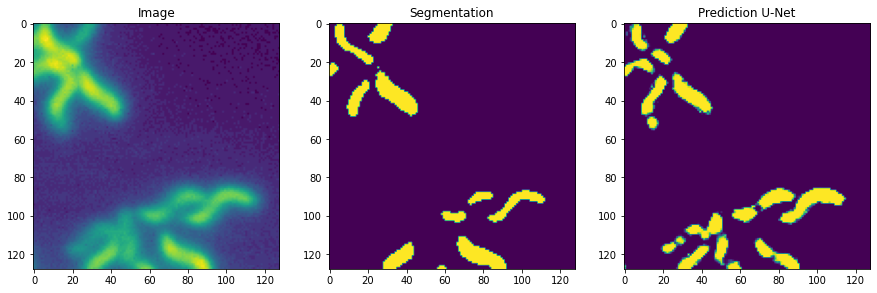

In [9]:
ix = 858

plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(X_test[ix,:,:,0])
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(y_test[ix,:,:,0])
plt.title('Segmentation')
plt.subplot(1,3,3)
plt.imshow(y_pred[ix,:,:,0])
plt.title('Prediction U-Net')

# E. coli (Olga)

In [10]:
X_test = data_Ecoli_Olga['X_test']
y_test = data_Ecoli_Olga['y_test']

model_pred = unet_inference(input_size = X_test.shape[1:])
model_pred.load_weights('../model_weights/family_machine/model_weights_Ecoli_Olga.h5')

y_pred = model_pred.predict(X_test)

Text(0.5, 1.0, 'Prediction U-Net')

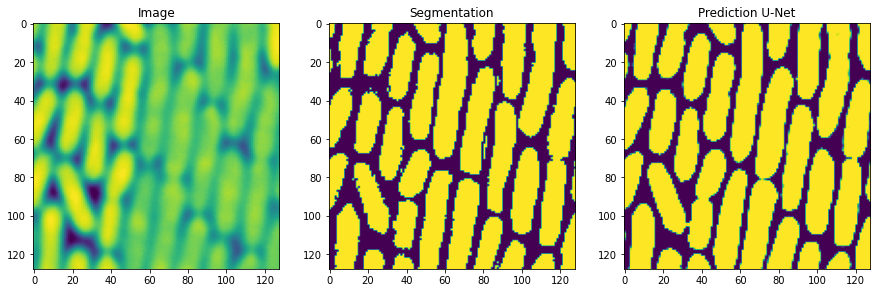

In [11]:
ix = 109

plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(X_test[ix,:,:,0])
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(y_test[ix,:,:,0])
plt.title('Segmentation')
plt.subplot(1,3,3)
plt.imshow(y_pred[ix,:,:,0])
plt.title('Prediction U-Net')

In [12]:
X_test = data_Ecoli_Olga_ero['X_test']
y_test = data_Ecoli_Olga_ero['y_test']

model_pred = unet_inference(input_size = X_test.shape[1:])
model_pred.load_weights('../model_weights/family_machine/model_weights_Ecoli_Olga.h5')

y_pred = model_pred.predict(X_test)

Text(0.5, 1.0, 'Prediction U-Net')

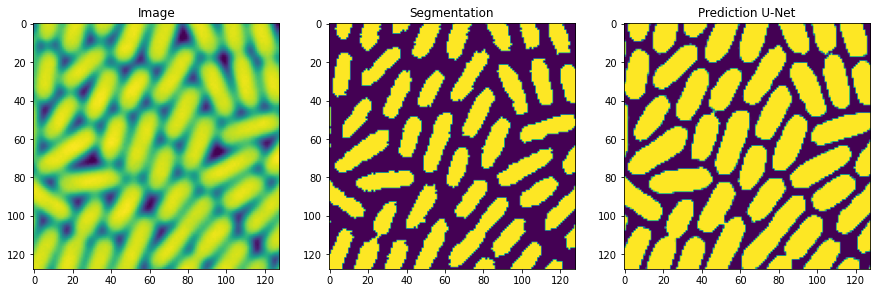

In [13]:
ix = 120

plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(X_test[ix,:,:,0])
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(y_test[ix,:,:,0])
plt.title('Segmentation')
plt.subplot(1,3,3)
plt.imshow(y_pred[ix,:,:,0])
plt.title('Prediction U-Net')

In [14]:
X_test = data_Ecoli_Olga_ero['X_test']
y_test = data_Ecoli_Olga_ero['y_test']

model_pred = unet_inference(input_size = X_test.shape[1:])
model_pred.load_weights('../model_weights/family_machine/model_weights_Ecoli_Olga_ero.h5')

y_pred = model_pred.predict(X_test)

Text(0.5, 1.0, 'Prediction U-Net')

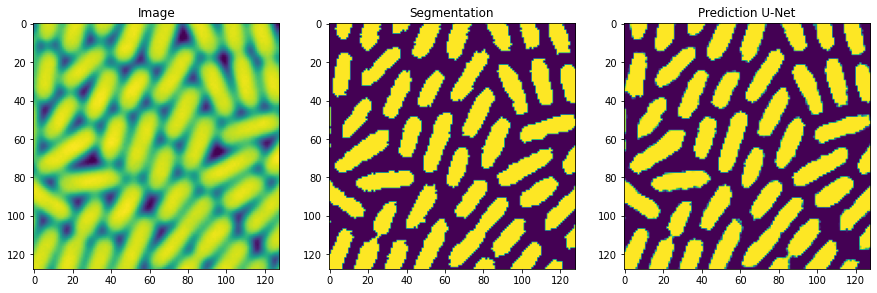

In [15]:
ix = 120

plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(X_test[ix,:,:,0])
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(y_test[ix,:,:,0])
plt.title('Segmentation')
plt.subplot(1,3,3)
plt.imshow(y_pred[ix,:,:,0])
plt.title('Prediction U-Net')

In [16]:
X_test = data_Ecoli_Olga_ero['X_test']
y_test = data_Ecoli_Olga_ero['y_test']

model_pred = unet_inference(input_size = X_test.shape[1:])
model_pred.load_weights('../model_weights/family_machine/model_weights_Ecoli_Olga_proc.h5')

y_pred = model_pred.predict(X_test)

Text(0.5, 1.0, 'Prediction U-Net')

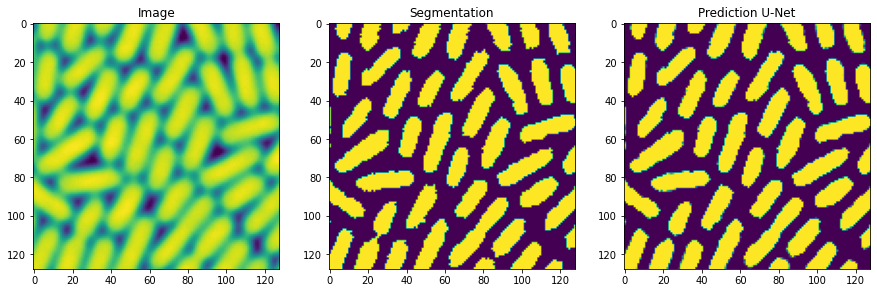

In [17]:
ix = 120

plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(X_test[ix,:,:,0])
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(y_test[ix,:,:,0])
plt.title('Segmentation')
plt.subplot(1,3,3)
plt.imshow(y_pred[ix,:,:,0])
plt.title('Prediction U-Net')

# E. coli

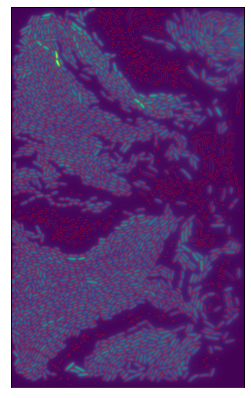

In [14]:
# pred = SegmentationPredictor('../bin/family_machine/best_model.hdf5')
#pred = SegmentationPredictor('../model_weights/family_machine/model_weights_FS144.h5')
pred = SegmentationPredictor('../model_weights/family_machine/model_weights_Ecoli.h5')
#pred = SegmentationPredictor('../bin/family_machine/best_model_all_gen.hdf5')
img_name = path + 'E_coli/test/img/img_10.tif'
seg_name = path + 'E_coli/test/mask/seg_10.tif'

seg = io.imread(seg_name)
# predict segmentation
pred.predict_single_image(img_name)

# # save segmentation
pred.generate_segmentation_overlay()
#pred.save_segmentation_image(path + 'E_coli/test_img_21.png', pred.fig)

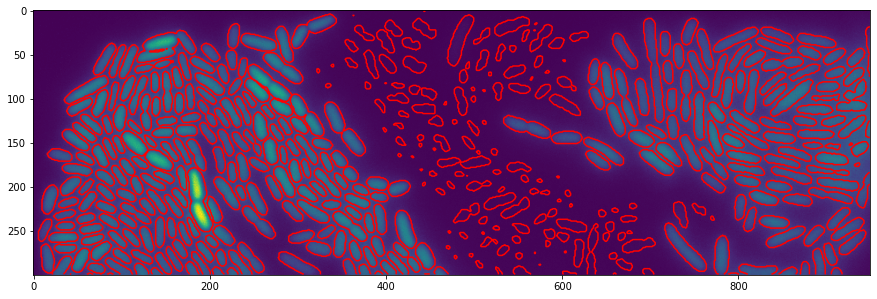

In [21]:
plt.figure(figsize = (15,15))
plt.imshow(pred.img[0:300,:])
plt.contour(pred.seg[0:300,:], levels = [0.5], colors=['r'])

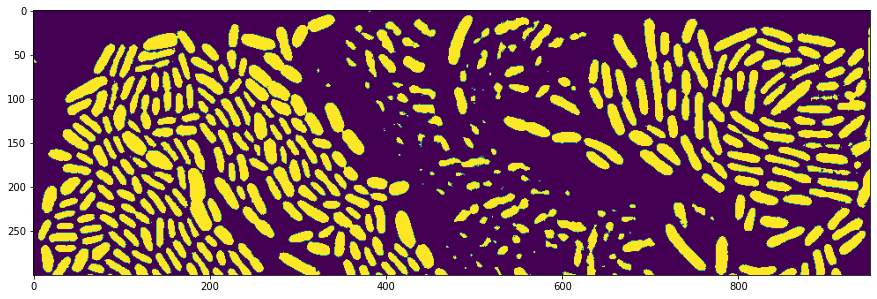

In [22]:
plt.figure(figsize = (15,15))
plt.imshow(seg[0:300,:])

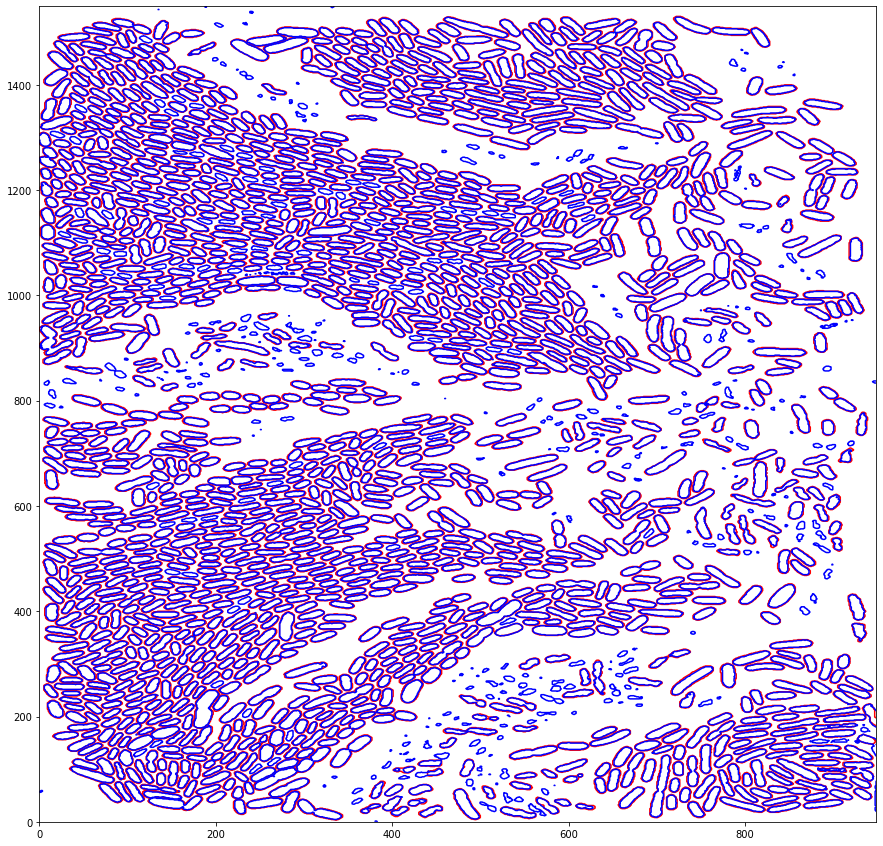

In [69]:
seg_clean = remove_small_objects(label_img, min_size=144)
plt.figure(figsize = (15,15))
#plt.imshow(pred.img)
plt.contour(seg_clean, levels = [0.5], colors=['r'])
plt.contour(seg, levels = [0.5], colors=['b'])

In [29]:
img = pred.seg
label_img = label(img, connectivity=img.ndim)
props = regionprops(label_img)

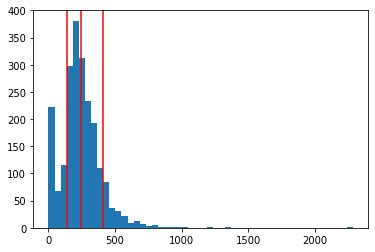

In [60]:
areas = [p.area for p in props]
np.quantile(areas, [0.2, 0.9])

plt.hist(areas, bins = 50)
plt.axvline(x=np.mean(areas), color='r')
plt.axvline(x=144, color='r')
plt.axvline(x=413, color='r')

In [59]:
np.quantile(areas, [0.2, 0.9])

array([144., 413.])

In [23]:
data = np.load('../data/unet/family_machine/E_coli/test/training_data_17.npz')
X_train = data['X_train']
y_train = data['y_train']

In [29]:
X_train.shape[1:]

(128, 128, 1)

In [30]:
from model import unet_inference

pred = SegmentationPredictor('../model_weights/family_machine/model_weights_Ecoli_gen.h5')

img_pad = pred.pad_image(img)
seg_pad = pred.pad_image(seg)

model_pred = unet_inference(input_size = X_train.shape[1:])
model_pred.load_weights(pred.model_weights)

model_pred.evaluate(X_train, y_train)
        
# from sklearn.metrics import accuracy_score
# accuracy_score(seg, pred.seg)
# pred.

9900/9900 [==============================] - 23s 2ms/step


[0.3186876958668834, 0.9557183384895325]

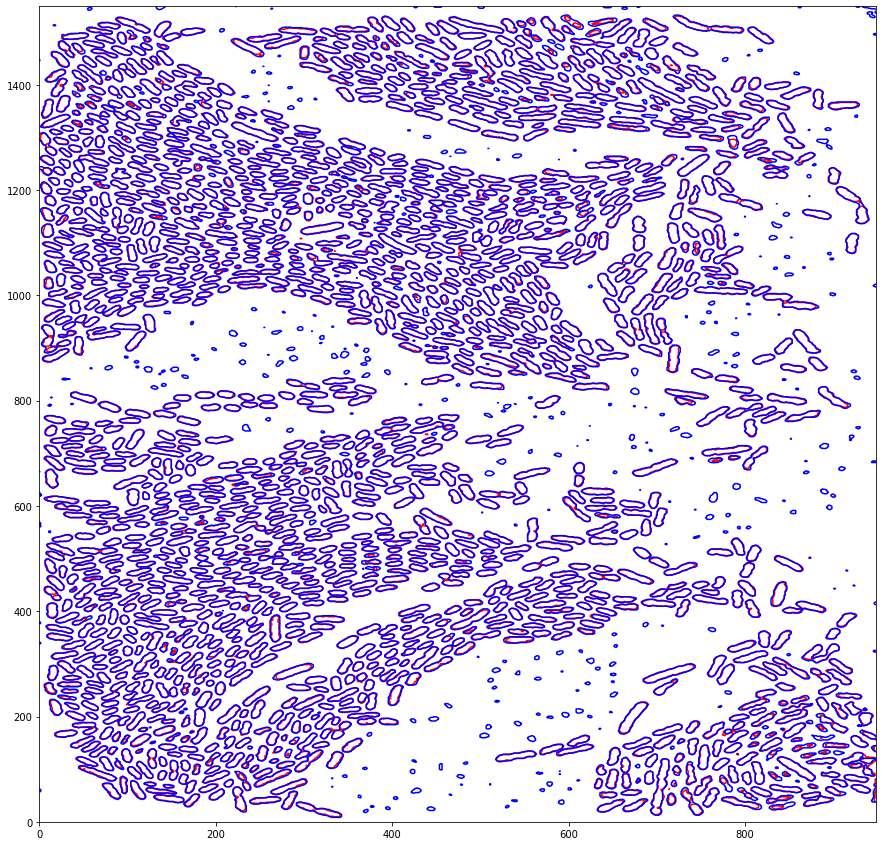

In [17]:
plt.figure(figsize = [15,15])
plt.contour(seg, levels=[0.5], colors = ['r'])
plt.contour(pred.seg, levels=[0.5], colors = ['b'])

# CB15-WT

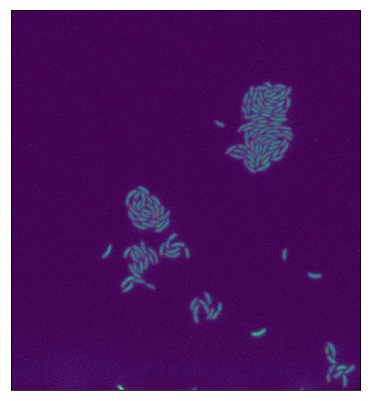

In [3]:
pred = SegmentationPredictor('../model_weights/family_machine/model_weights_CB15-WT.h5')
img_name = path + 'CB15-WT/test/img/Cb15WT_frame110.tif'

# predict segmentation
pred.predict_single_image(img_name)

# # save segmentation
pred.generate_segmentation_overlay()
pred.save_segmentation_image(path + 'CB15-WT/test/seg/Cb15WT_frame110_seg.png', pred.fig)

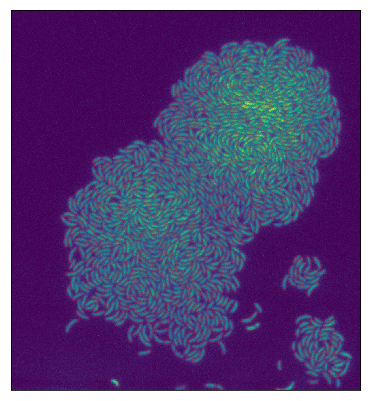

In [4]:
img_name = path + 'CB15-WT/test/img/Cb15WT_frame160.tif'

# predict segmentation
pred.predict_single_image(img_name)

# # save segmentation
pred.generate_segmentation_overlay()
pred.save_segmentation_image(path + 'CB15-WT/test/seg/Cb15WT_frame160_seg.png', pred.fig)

# CB15-flgH

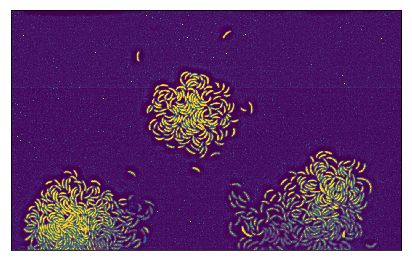

In [5]:
pred = SegmentationPredictor('../model_weights/family_machine/model_weights_CB15-flgH.h5')
img_name = path + 'CB15-flgH/test/img/CB-FlgH_frame110.tif'

# predict segmentation
pred.predict_single_image(img_name)

# # save segmentation
pred.generate_segmentation_overlay()
pred.save_segmentation_image(path + 'CB15-flgH/test/seg/CB15FlgH_frame110_seg.png', pred.fig)

# FS144

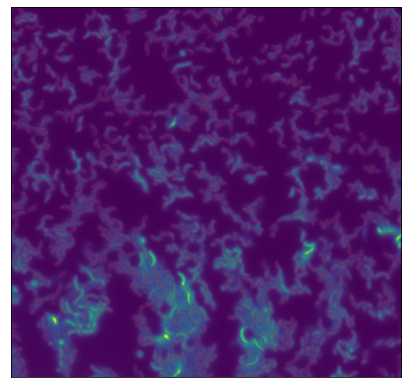

In [15]:
pred = SegmentationPredictor('../model_weights/family_machine/model_weights_FS144.h5')
img_name = path + 'FS144/test/img/GD_04092019AlgCo_Cas_Pos57_TXRED_Exp001_frame100_cut.png'

# predict segmentation
pred.predict_single_image(img_name)

# save segmentation
pred.generate_segmentation_overlay()
#pred.save_segmentation_image(path + 'FS144/test/seg/pos33-mCherry_dual-A10100_seg.png', pred.fig)

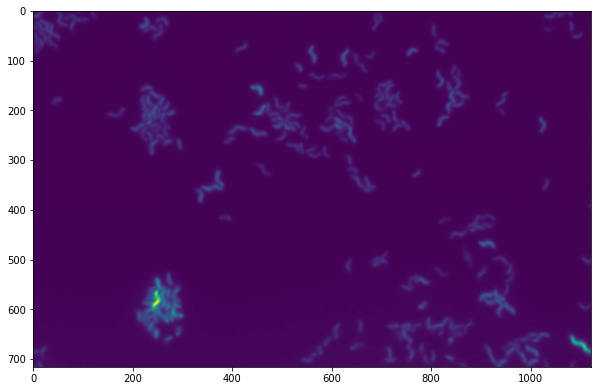

In [13]:
img = io.imread('../data/unet/family_machine/FS144/test/img/pos33-mCherry_dual-A10200_cut.png')
seg = io.imread('../data/unet/family_machine/FS144/test/mask/pos33-mCherry_dual-A10200_seg_2_new.png')

plt.figure(figsize = (10,10))
plt.imshow(img)

# ZF270g

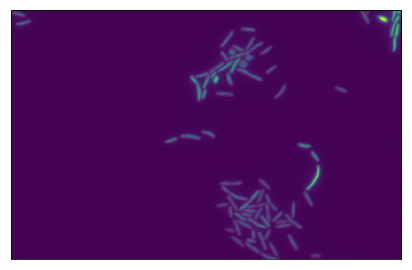

In [4]:
pred = SegmentationPredictor('../model_weights/family_machine/model_weights_ZF270g.h5')
img_name = path + 'ZF270g/test/img/pos33-eGFP_dual-A10100_cut.png'

# predict segmentation
pred.predict_single_image(img_name)

# save segmentation
pred.generate_segmentation_overlay()
pred.save_segmentation_image(path + 'ZF270g/test/seg/pos33-eGFP_dual-A10100_seg.png', pred.fig)